# Week 41 - Exercises

OLS REGRESSION

1. Plain GD with fixed learning rate

In [52]:
import autograd.numpy as np
import matplotlib.pyplot as plt
from random import random, seed
from autograd import grad
from sklearn.model_selection import train_test_split

np.random.seed(2018)

In [176]:
def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

def MSE(y_data,y_model):
    n = np.size(y_model)
    y_data = y_data.reshape(-1, 1)
    y_model = y_model.reshape(-1, 1)
    return np.sum((y_data-y_model)**2)/n

def create_X(x, y, n ):
	if len(x.shape) > 1:
		x = np.ravel(x)
		y = np.ravel(y)

	N = len(x)
	l = int((n+1)*(n+2)/2)
	X = np.ones((N,l))

	for i in range(1,n+1):
		q = int((i)*(i+1)/2)
		for k in range(i+1):
			X[:,q+k] = (x**(i-k))*(y**k)

	return X

In [181]:
n = 100
max_degree = 15
x = np.random.rand(n)
y = np.random.rand(n)
x = np.sort(x)
y = np.sort(y)

x, y = np.meshgrid(x,y)
z = FrankeFunction(x, y) + 0.1*np.random.normal(0,1, x.shape)

x = x.reshape(-1,1) # reshaping the meshgrid in two arrays
y = y.reshape(-1,1)
z = z.reshape(-1,1)

X = create_X(x, y, max_degree) # creating the design matrix

X_train, X_test, z_train, z_test = train_test_split(X, z, test_size = 0.2, random_state = 42)

In [182]:
def gradient_descent(X, y, num_iter = 1000):
    XT_X = X.T @ X
    H = (2.0/n)*XT_X
    EigValues, EigVectors = np.linalg.eig(H)

    theta = np.random.randn(X.shape[1], 1)
    eta = 1.0/np.max(EigValues)

    for iter in range(num_iter):
        gradients = 2.0/n* X.T @ ((X @ theta) - y)
        theta -= np.real(eta)*gradients
    return theta

def gradient_descent_momentum(X, y, num_iter = 1000, change = 0.0, delta_momentum = 0.3):
    XT_X = X.T @ X
    H = (2.0/n)*XT_X
    EigValues, EigVectors = np.linalg.eig(H)

    theta = np.random.randn(X.shape[1], 1)
    eta = 1.0/np.max(EigValues)

    for iter in range(num_iter):
        gradients = 2.0/n* X.T @ ((X @ theta) - y)
        new_change = np.real(eta)*gradients + delta_momentum*change
        theta -= new_change
        change = new_change
    return theta

def learning_schedule(t, t0, t1):
    return t0/(t+t1)

def stochastic_gradient_descent(X, y, num_epochs = 100, M = 5, t0 = 5, t1 = 50):
    theta = np.random.randn(X.shape[1], 1)
    m = int(n/M)
    for epoch in range(num_epochs):
        for i in range(m):
            rand_index = M + np.random.randint(m)
            x_i = X[rand_index:rand_index+M]
            y_i = y[rand_index:rand_index+M]
            gradients = (2.0/M)*x_i.T @ ((x_i @ theta) - y_i)
            eta = learning_schedule(epoch*m + i, t0, t1)
            theta -= eta*gradients
    return theta

def stochastic_gradient_descent_momentum(X, y, num_epochs = 100, M = 5, t0 = 5, t1 = 50, change = 0.0, delta_momentum = 0.3):
    theta = np.random.randn(X.shape[1], 1)
    m = int(n/M)
    for epoch in range(num_epochs):
        for i in range(m):
            rand_index = M + np.random.randint(m)
            x_i = X[rand_index:rand_index+M]
            y_i = y[rand_index:rand_index+M]
            gradients = (2.0/M)*x_i.T @ ((x_i @ theta) - y_i)
            eta = learning_schedule(epoch*m + i, t0, t1)
            new_change = eta*gradients + delta_momentum*change
            theta -= new_change
            change = new_change
    return theta

def CostOLS(y, X, theta):
    return np.sum((y - X @ theta)**2)

def RMSprop(X, y, num_epochs = 100, M = 5, eta = 0.01, rho = 0.90, delta = 1e-8):
    training_gradient = grad(CostOLS, 2)
    theta = np.random.randn(X.shape[1], 1)
    m = int(n/M)
    for epoch in range(num_epochs):
        Giter = 0.0
        for i in range(m):
            rand_index = M+np.random.randint(m)
            x_i = X[rand_index:rand_index+M]
            y_i = y[rand_index:rand_index+M]
            gradients = (1.0/M)*training_gradient(y_i, x_i, theta)
            Giter = (rho*Giter + (1-rho)*gradients*gradients)
            update = gradients*eta/(delta + np.sqrt(Giter))
            theta -= update
    return theta

def Adam(X, y, num_epochs = 100, M = 5, eta = 0.01, beta1 = 0.9, beta2 = 0.999, delta = 1e-7):
    training_gradient = grad(CostOLS, 2)
    theta = np.random.randn(X.shape[1], 1)
    m = int(n/M)

    iter = 0
    for epoch in range(num_epochs):
        first_moment = 0.0
        second_moment = 0.0
        iter += 1
        for i in range(m):
            rand_index = M+np.random.randint(m)
            x_i = X[rand_index:rand_index+M]
            y_i = y[rand_index:rand_index+M]
            gradients = (1.0/M)*training_gradient(y_i, x_i, theta)
            first_moment = beta1*first_moment + (1-beta1)*gradients
            second_moment = beta2*second_moment + (1-beta2)*gradients*gradients
            first_term = first_moment/(1.0-beta1**iter)
            second_term = second_moment/(1.0-beta2**iter)
            update = eta*first_term/(np.sqrt(second_term)+delta)
            theta -= update
    return theta

def Adagrad_SGD(X, y, num_epochs = 100, M = 5, eta = 0.01, delta = 1e-8, change = 0.0, delta_momentum = 0.3, momentum = False):
    m = int(n/M)
    theta = np.random.randn(X.shape[1], 1)
    training_gradient = grad(CostOLS, 2)
    for epoch in range(num_epochs):
        Giter = 0.0
        for i in range(m):
            rand_index = M+np.random.randint(m)
            x_i = X[rand_index:rand_index+M]
            y_i = y[rand_index:rand_index+M]
            gradients = (1.0/M)*training_gradient(y_i, x_i, theta)
            Giter += gradients*gradients
            update = gradients*eta/ (delta + np.sqrt(Giter))
            if momentum == False:
                theta -= update
            if momentum == True:
                new_change = update + delta_momentum*change
                theta -= new_change
                change = new_change
    return theta

def Adagrad_GD(X, y, num_iter = 1000, eta = 0.01, delta = 1e-8, momentum = False, change = 0.0, delta_momentum = 0.3):
    XT_X = X.T @ X
    H = (2.0/n)*XT_X
    EigValues, EigVectors = np.linalg.eig(H)
    theta = np.random.randn(X.shape[1], 1)
    eta = 1.0/np.max(EigValues)
    training_gradient = grad(CostOLS, 2)
    Giter = 0.0
    for iter in range(num_iter):
        gradients = 2.0/n* X.T @ ((X @ theta) - y)
        Giter += gradients*gradients
        update = np.real(eta)*gradients/ (delta + np.sqrt(Giter))
        if momentum == False:
            theta -= update
        if momentum == True:
            new_change = update + delta_momentum*change
            theta -= new_change
            change = new_change
    return theta

In [183]:
def degree_MSE(X_train, X_test, z_train, z_test, max_degree, method, momentum = False):
    MSE_train = np.zeros(max_degree)
    MSE_test = np.zeros(max_degree)

    for i in range(1, max_degree+1):
        c = int((i+2)*(i+1)/2)
        X_tilde = X_train[:,0:c]
        
        if method == gradient_descent:
            theta = gradient_descent(X_tilde, z_train, num_iter = 1000)
        elif method == gradient_descent_momentum:
            theta = gradient_descent_momentum(X_tilde, z_train, num_iter = 1000, change = 0.0, delta_momentum = 0.3)
        elif method == stochastic_gradient_descent:
            theta = stochastic_gradient_descent(X_tilde, z_train, num_epochs = 100, M = 5, t0 = 5, t1 = 50)
        elif method == stochastic_gradient_descent_momentum:
            theta = stochastic_gradient_descent_momentum(X_tilde, z_train, num_epochs = 100, M = 5, t0 = 5, t1 = 50, change = 0.0, delta_momentum = 0.3)
        elif method == Adagrad_SGD:
            if momentum == False: 
                theta = Adagrad_SGD(X_tilde, z_train, num_epochs = 100, M = 5, eta = 0.01, delta = 1e-8, change = 0.0, delta_momentum = 0.3, momentum = False)
            else:
                theta = Adagrad_SGD(X_tilde, z_train, num_epochs = 100, M = 5, eta = 0.01, delta = 1e-8, change = 0.0, delta_momentum = 0.3, momentum = True)
        elif method == Adagrad_GD:
            if momentum == False: 
                theta = Adagrad_GD(X_tilde, z_train, num_iter = 1000, eta = 0.01, delta = 1e-8, momentum = False, change = 0.0, delta_momentum = 0.3)
            else:
                theta = Adagrad_GD(X_tilde, z_train, num_iter = 1000, eta = 0.01, delta = 1e-8, momentum = True, change = 0.0, delta_momentum = 0.3)
        elif method == RMSprop:
            theta = RMSprop(X_tilde, z_train, num_epochs = 100, M = 5, eta = 0.01, rho = 0.90, delta = 1e-8)
        elif method == Adam:
            theta = Adam(X_tilde, z_train, num_epochs = 100, M = 5, eta = 0.01, beta1 = 0.9, beta2 = 0.999, delta = 1e-7)
        

        ypredict = X_tilde @ theta
        ypredict_test = X_test[:,0:c] @ theta

        MSE_train[i-1] = MSE(z_train, ypredict)
        MSE_test[i-1] = MSE(z_test, ypredict_test)

    return MSE_train, MSE_test

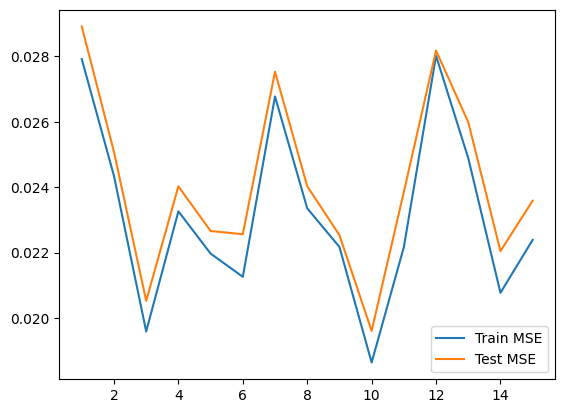

In [184]:
MSE_train, MSE_test = degree_MSE(X_train, X_test, z_train, z_test, max_degree, gradient_descent)

plt.plot(np.arange(1, max_degree+1), MSE_train, label = "Train MSE")
plt.plot(np.arange(1, max_degree+1), MSE_test, label = "Test MSE")
plt.legend()
plt.show()

2. Plain GD with fixed learning rate and momentum

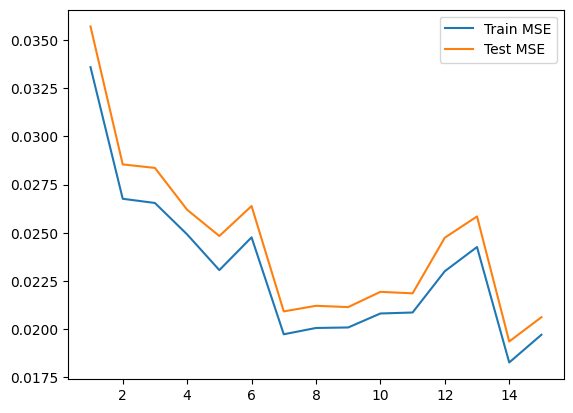

In [112]:
MSE_train, MSE_test = degree_MSE(X_train, X_test, z_train, z_test, max_degree, gradient_descent_momentum)

plt.plot(np.arange(1, max_degree+1), MSE_train, label = "Train MSE")
plt.plot(np.arange(1, max_degree+1), MSE_test, label = "Test MSE")
plt.legend()
plt.show()

Comparison: .......

3. Stochastic gradient descent 

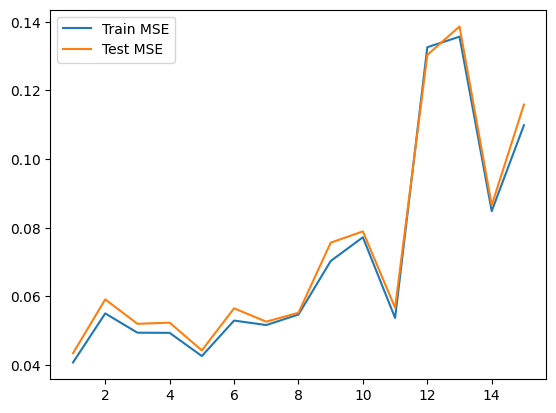

In [145]:
MSE_train, MSE_test = degree_MSE(X_train, X_test, z_train, z_test, max_degree, stochastic_gradient_descent)

plt.plot(np.arange(1, max_degree+1), MSE_train, label = "Train MSE")
plt.plot(np.arange(1, max_degree+1), MSE_test, label = "Test MSE")
plt.legend()
plt.show()

Stochastic gradient descent with momentum:

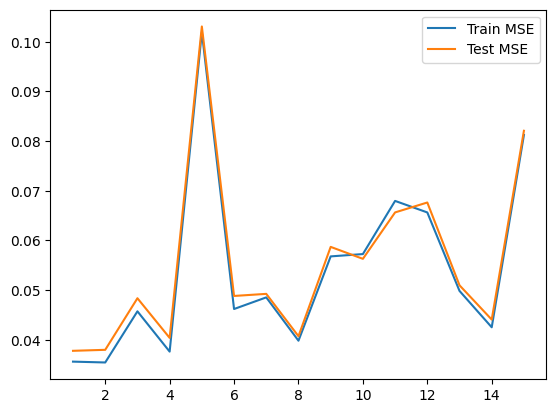

In [115]:
MSE_train, MSE_test = degree_MSE(X_train, X_test, z_train, z_test, max_degree, stochastic_gradient_descent_momentum)

plt.plot(np.arange(1, max_degree+1), MSE_train, label = "Train MSE")
plt.plot(np.arange(1, max_degree+1), MSE_test, label = "Test MSE")
plt.legend()
plt.show()

Discussion: .........

4a. Adagrad without and with momentum for GD

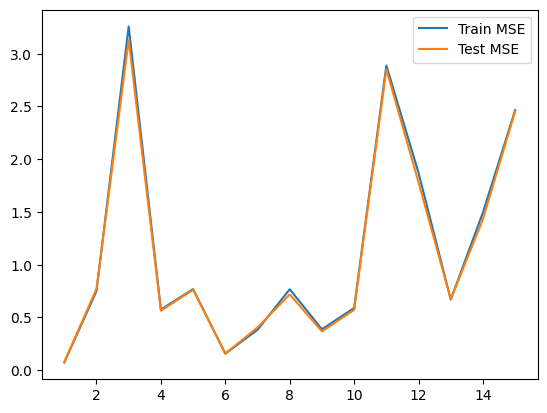

In [158]:
# without momentum
MSE_train, MSE_test = degree_MSE(X_train, X_test, z_train, z_test, max_degree, Adagrad_GD, momentum = False)

plt.plot(np.arange(1, max_degree+1), MSE_train, label = "Train MSE")
plt.plot(np.arange(1, max_degree+1), MSE_test, label = "Test MSE")
plt.legend()
plt.show()

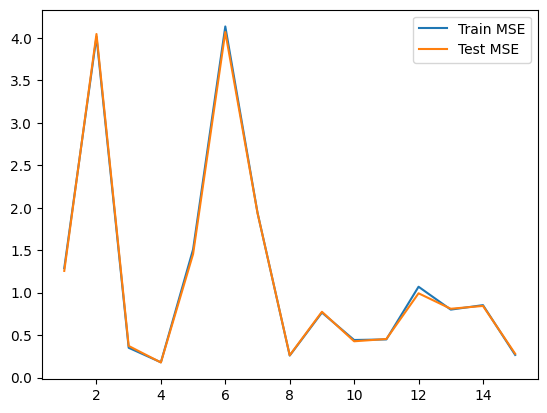

In [159]:
# with momentum
MSE_train, MSE_test = degree_MSE(X_train, X_test, z_train, z_test, max_degree, Adagrad_GD, momentum = True)

plt.plot(np.arange(1, max_degree+1), MSE_train, label = "Train MSE")
plt.plot(np.arange(1, max_degree+1), MSE_test, label = "Test MSE")
plt.legend()
plt.show()

4a. Adagrad without and with momentum for SGD

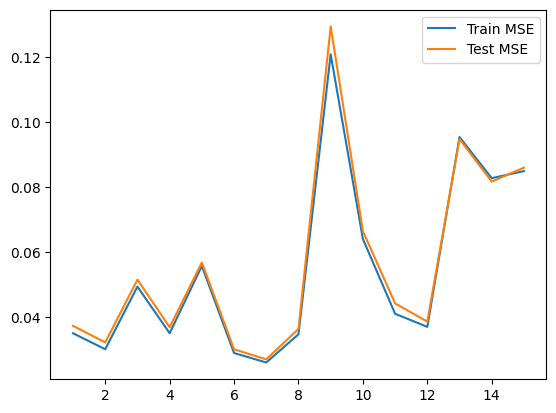

In [153]:
# without momentum
MSE_train, MSE_test = degree_MSE(X_train, X_test, z_train, z_test, max_degree, Adagrad_SGD, momentum = False)

plt.plot(np.arange(1, max_degree+1), MSE_train, label = "Train MSE")
plt.plot(np.arange(1, max_degree+1), MSE_test, label = "Test MSE")
plt.legend()
plt.show()

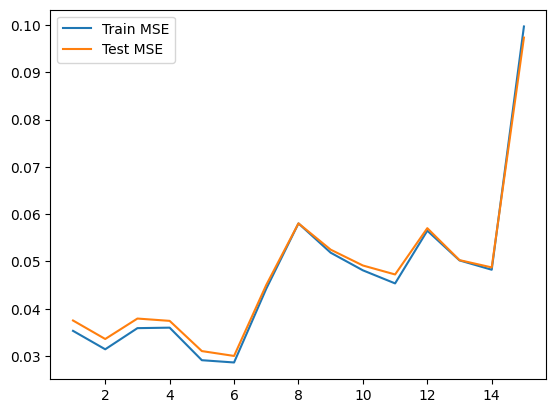

In [154]:
# with momentum 
MSE_train, MSE_test = degree_MSE(X_train, X_test, z_train, z_test, max_degree, Adagrad_SGD, momentum = True)

plt.plot(np.arange(1, max_degree+1), MSE_train, label = "Train MSE")
plt.plot(np.arange(1, max_degree+1), MSE_test, label = "Test MSE")
plt.legend()
plt.show()

5. RMSprop and Adam

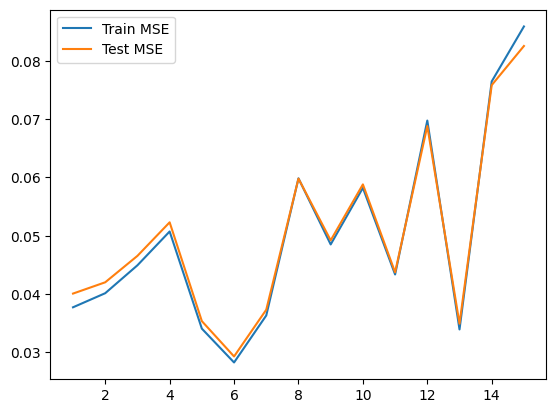

In [121]:
MSE_train, MSE_test = degree_MSE(X_train, X_test, z_train, z_test, max_degree, RMSprop)

plt.plot(np.arange(1, max_degree+1), MSE_train, label = "Train MSE")
plt.plot(np.arange(1, max_degree+1), MSE_test, label = "Test MSE")
plt.legend()
plt.show()

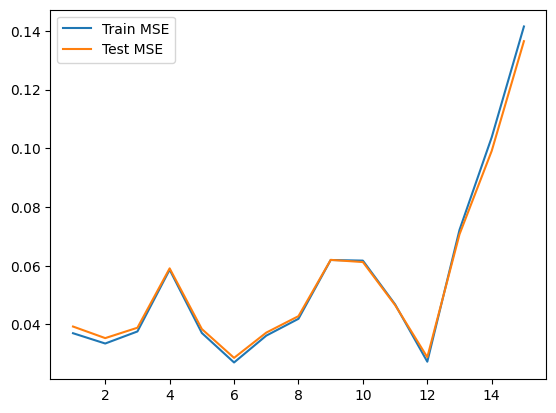

In [124]:
MSE_train, MSE_test = degree_MSE(X_train, X_test, z_train, z_test, max_degree, Adam)

plt.plot(np.arange(1, max_degree+1), MSE_train, label = "Train MSE")
plt.plot(np.arange(1, max_degree+1), MSE_test, label = "Test MSE")
plt.legend()
plt.show()

RIDGE REGRESSION

In [198]:
def gradient_descent(X, y, lmb = 0.001, num_iter = 1000):
    XT_X = X.T @ X
    H = (2.0 / len(X) )* XT_X + 2.0 * lmb * np.eye(len(XT_X))
    EigValues, EigVectors = np.linalg.eig(H)

    theta = np.random.randn(X.shape[1], 1)
    eta = 1.0/np.max(EigValues)

    for iter in range(num_iter):
        gradients = 2.0 / len(X) * X.T @ ((X @ theta) - y) + 2.0 * lmb * theta
        theta -= np.real(eta) * gradients
    return theta

def gradient_descent_momentum(X, y, lmb = 0.001, num_iter = 1000, change = 0.0, delta_momentum = 0.3):
    XT_X = X.T @ X
    H = (2.0 / len(X)) * XT_X + 2.0 * lmb * np.eye(len(XT_X))
    EigValues, EigVectors = np.linalg.eig(H)

    theta = np.random.randn(X.shape[1], 1)
    eta = 1.0/np.max(EigValues)

    for iter in range(num_iter):
        gradients = 2.0 / len(X) * X.T @ ((X @ theta) - y) + 2.0 * lmb * theta
        new_change = np.real(eta)*gradients + delta_momentum*change
        theta -= new_change
        change = new_change
    return theta

def learning_schedule(t, t0, t1):
    return t0/(t+t1)

def stochastic_gradient_descent(X, y, lmb = 0.001, num_epochs = 100, M = 5, t0 = 5, t1 = 50):
    theta = np.random.randn(X.shape[1], 1)
    m = int(n/M)
    for epoch in range(num_epochs):
        for i in range(m):
            rand_index = M + np.random.randint(m)
            x_i = X[rand_index:rand_index+M]
            y_i = y[rand_index:rand_index+M]
            gradients = 2.0 / len(X) * X.T @ ((X @ theta) - y) + 2.0 * lmb * theta
            eta = learning_schedule(epoch*m + i, t0, t1)
            theta -= eta*gradients
    return theta

def stochastic_gradient_descent_momentum(X, y, lmb = 0.001, num_epochs = 100, M = 5, t0 = 5, t1 = 50, change = 0.0, delta_momentum = 0.3):
    theta = np.random.randn(X.shape[1], 1)
    m = int(n/M)
    for epoch in range(num_epochs):
        for i in range(m):
            rand_index = M + np.random.randint(m)
            x_i = X[rand_index:rand_index+M]
            y_i = y[rand_index:rand_index+M]
            gradients = 2.0 / len(X) * X.T @ ((X @ theta) - y) + 2.0 * lmb * theta
            eta = learning_schedule(epoch*m + i, t0, t1)
            new_change = eta*gradients + delta_momentum*change
            theta -= new_change
            change = new_change
    return theta

def CostRidge(y, X, theta, lmb = 0.001):
    return np.sum((y - X @ theta)**2) + lmb * np.sum(theta**2)

def RMSprop(X, y, num_epochs = 100, M = 5, eta = 0.01, rho = 0.90, delta = 1e-8):
    training_gradient = grad(CostRidge, 2)
    theta = np.random.randn(X.shape[1], 1)
    m = int(n/M)
    for epoch in range(num_epochs):
        Giter = 0.0
        for i in range(m):
            rand_index = M+np.random.randint(m)
            x_i = X[rand_index:rand_index+M]
            y_i = y[rand_index:rand_index+M]
            gradients = (1.0/M)*training_gradient(y_i, x_i, theta)
            Giter = (rho*Giter + (1-rho)*gradients*gradients)
            update = gradients*eta/(delta + np.sqrt(Giter))
            theta -= update
    return theta

def Adam(X, y, num_epochs = 100, lmb = 0.0001, M = 5, eta = 0.01, beta1 = 0.9, beta2 = 0.999, delta = 1e-7):
    training_gradient = grad(CostRidge(X, y, lmb), 2)
    theta = np.random.randn(X.shape[1], 1)
    m = int(n/M)

    iter = 0
    for epoch in range(num_epochs):
        first_moment = 0.0
        second_moment = 0.0
        iter += 1
        for i in range(m):
            rand_index = M+np.random.randint(m)
            x_i = X[rand_index:rand_index+M]
            y_i = y[rand_index:rand_index+M]
            gradients = (1.0/M)*training_gradient(y_i, x_i, theta)
            first_moment = beta1*first_moment + (1-beta1)*gradients
            second_moment = beta2*second_moment + (1-beta2)*gradients*gradients
            first_term = first_moment/(1.0-beta1**iter)
            second_term = second_moment/(1.0-beta2**iter)
            update = eta*first_term/(np.sqrt(second_term)+delta)
            theta -= update
    return theta

def Adagrad_SGD(X, y, lmb = 0.0001, num_epochs = 100, M = 5, eta = 0.01, delta = 1e-8, change = 0.0, delta_momentum = 0.3, momentum = False):
    m = int(n/M)
    theta = np.random.randn(X.shape[1], 1)
    training_gradient = grad(CostRidge(X, y, lmb), 2)
    for epoch in range(num_epochs):
        Giter = 0.0
        for i in range(m):
            rand_index = M+np.random.randint(m)
            x_i = X[rand_index:rand_index+M]
            y_i = y[rand_index:rand_index+M]
            gradients = (1.0/M)*training_gradient(y_i, x_i, theta)
            Giter += gradients*gradients
            update = gradients*eta/ (delta + np.sqrt(Giter))
            if momentum == False:
                theta -= update
            if momentum == True:
                new_change = update + delta_momentum*change
                theta -= new_change
                change = new_change
    return theta

def Adagrad_GD(X, y, lmb = 0.001, num_iter = 1000, eta = 0.01, delta = 1e-8, momentum = False, change = 0.0, delta_momentum = 0.3):
    XT_X = X.T @ X
    H = (2.0 / len(X)) * XT_X + 2.0 * lmb * np.eye(len(XT_X))
    EigValues, EigVectors = np.linalg.eig(H)
    theta = np.random.randn(X.shape[1], 1)
    eta = 1.0/np.max(EigValues)
    training_gradient = grad(CostOLS, 2)
    Giter = 0.0
    for iter in range(num_iter):
        gradients = 2.0 / len(X) * X.T @ ((X @ theta) - y) + 2.0 * lmb * theta
        Giter += gradients*gradients
        update = np.real(eta)*gradients/ (delta + np.sqrt(Giter))
        if momentum == False:
            theta -= update
        if momentum == True:
            new_change = update + delta_momentum*change
            theta -= new_change
            change = new_change
    return theta

In [199]:
def lambda_MSE(X_train, X_test, z_train, z_test, max_degree, method, lmb, momentum):
    MSE_train = np.zeros(max_degree)
    MSE_test = np.zeros(max_degree)

    for i in range(1, max_degree+1):
        c = int((i+2)*(i+1)/2)
        X_tilde = X_train[:,0:c]
        
        if method == gradient_descent:
            theta = gradient_descent(X_tilde, z_train, lmb, num_iter = 1000)
        elif method == gradient_descent_momentum:
            theta = gradient_descent_momentum(X_tilde, z_train, lmb, num_iter = 1000, change = 0.0, delta_momentum = 0.3)
        elif method == stochastic_gradient_descent:
            theta = stochastic_gradient_descent(X_tilde, z_train, num_epochs = 100, M = 5, t0 = 5, t1 = 50)
        elif method == stochastic_gradient_descent_momentum:
            theta = stochastic_gradient_descent_momentum(X_tilde, z_train, num_epochs = 100, M = 5, t0 = 5, t1 = 50, change = 0.0, delta_momentum = 0.3)
        elif method == Adagrad_SGD:
            if momentum == False: 
                theta = Adagrad_SGD(X_tilde, z_train, lmb = 0.001, num_epochs = 100, M = 5, eta = 0.01, delta = 1e-8, change = 0.0, delta_momentum = 0.3, momentum = False)
            else:
                theta = Adagrad_SGD(X_tilde, z_train, num_epochs = 100, M = 5, eta = 0.01, delta = 1e-8, change = 0.0, delta_momentum = 0.3, momentum = True)
        elif method == Adagrad_GD:
            if momentum == False: 
                theta = Adagrad_GD(X_tilde, z_train, num_iter = 1000, eta = 0.01, delta = 1e-8, momentum = False, change = 0.0, delta_momentum = 0.3)
            else:
                theta = Adagrad_GD(X_tilde, z_train, num_iter = 1000, eta = 0.01, delta = 1e-8, momentum = True, change = 0.0, delta_momentum = 0.3)
        elif method == RMSprop:
            theta = RMSprop(X_tilde, z_train, num_epochs = 100, M = 5, eta = 0.01, rho = 0.90, delta = 1e-8)
        elif method == Adam:
            theta = Adam(X_tilde, z_train, num_epochs = 100, M = 5, eta = 0.01, beta1 = 0.9, beta2 = 0.999, delta = 1e-7)

        ypredict = X_tilde @ theta
        ypredict_test = X_test[:,0:c] @ theta

        MSE_train[i-1] = MSE(z_train, ypredict)
        MSE_test[i-1] = MSE(z_test, ypredict_test)

    return MSE_train, MSE_test